# Intro to Autoencoders

This lab introduces autoencoders with three examples: the basics, image denoising, and anomaly detection.

An autoencoder is a special type of neural network that is trained to copy its input to its output. For example, given an image of a handwritten digit, an autoencoder first encodes the image into a lower dimensional latent representation, then decodes the latent representation back to an image. An autoencoder learns to compress the data while minimizing the reconstruction error.

## Import TensorFlow and other libraries

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

## Load the dataset
To start, you will train the basic autoencoder using the Fashion MNIST dataset. Each image in this dataset is 28x28 pixels.

In [ ]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


## First example: Basic autoencoder
![Basic autoencoder results](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/intro_autoencoder_result.png?raw=1)

Define an autoencoder with two Dense layers: an `encoder`, which compresses the images into a 64 dimensional latent vector, and a `decoder`, that reconstructs the original image from the latent space.

To define your model, use the [Keras Model Subclassing API](https://www.tensorflow.org/guide/keras/custom_layers_and_models).


In [ ]:
class Autoencoder(Model):
  def __init__(self, latent_dim, shape):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(tf.math.reduce_prod(shape).numpy(), activation='sigmoid'),
      layers.Reshape(shape)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


shape = x_test.shape[1:]
latent_dim = 64
autoencoder = Autoencoder(latent_dim, shape)


In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

Train the model using `x_train` as both the input and the target. The `encoder` will learn to compress the dataset from 784 dimensions to the latent space, and the `decoder` will learn to reconstruct the original images.
.

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0405 - val_loss: 0.0134
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0124 - val_loss: 0.0108
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0105 - val_loss: 0.0100
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0098 - val_loss: 0.0096
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0095 - val_loss: 0.0094
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0093 - val_loss: 0.0093
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0092 - val_loss: 0.0092
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0091 - val_loss: 0.0091
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0090 - val_loss: 0.0091
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0090 - val_loss: 0.0090


Now that the model is trained, let us test it by encoding and decoding images from the test set.

In [ ]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

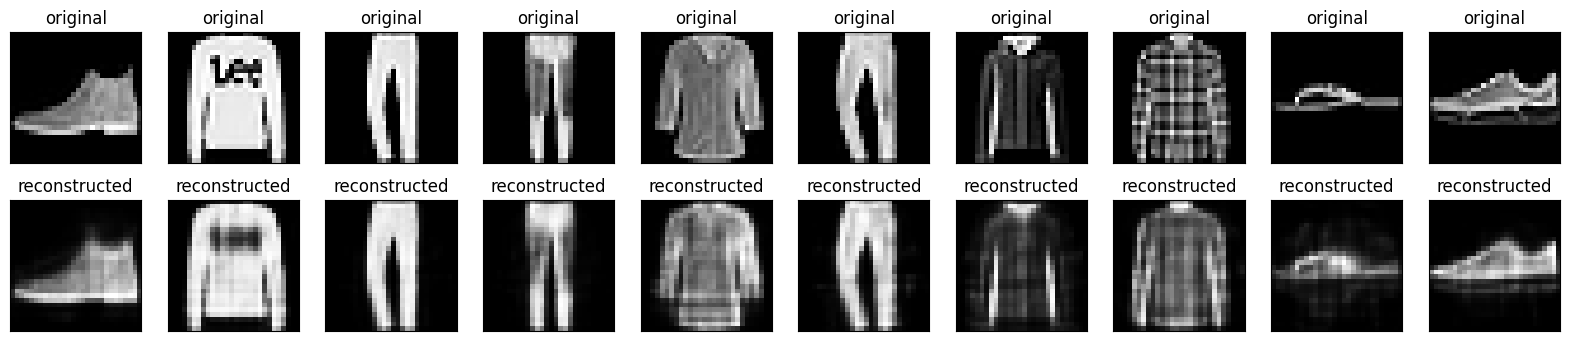

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

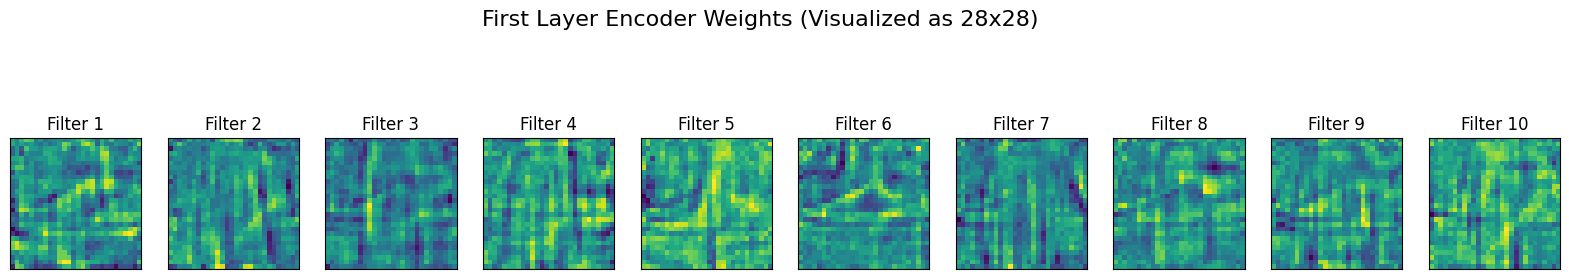

In [ ]:
# **************************************
# TASK 1 - VISUALIZE AUTOENCODER WEIGHTS
# **************************************

# Observe what the autoencoder is learning in its first layer. After
# training the autoencoder, extract weights from the first layer of the
# encoder. Reshape and visualize a few of these weight vectors as 28x28
# images using matplotlib.

# Notice if the filters capture edge-like or blob-like patterns. Discuss
# how this is similar to features learned in CNNs.

# WRITE YOUR CODE HERE
# Extracting the weights from the encoder's first Dense layer
weights, biases = autoencoder.encoder.layers[1].get_weights()
# Transpose to get 64 filters of shape (784,)
weights = weights.T
# Plot a few of them reshaped to 28x28
n_filters = 10  # You can change this
plt.figure(figsize=(20, 4))
for i in range(n_filters):
    ax = plt.subplot(1, n_filters, i + 1)
    plt.imshow(weights[i].reshape(28, 28), cmap='viridis')  # or cmap='gray'
    plt.title(f"Filter {i+1}")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.suptitle("First Layer Encoder Weights (Visualized as 28x28)", fontsize=16)
plt.show()

# **************************************
# **************************************

## Second example: Image denoising


![Image denoising results](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/image_denoise_fmnist_results.png?raw=1)

An autoencoder can also be trained to remove noise from images. In the following section, you will create a noisy version of the Fashion MNIST dataset by applying random noise to each image. You will then train an autoencoder using the noisy image as input, and the original image as the target.

Let us reimport the dataset to omit the modifications made earlier.

In [ ]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

In [ ]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


Adding random noise to the images

In [ ]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

Plot the noisy images.


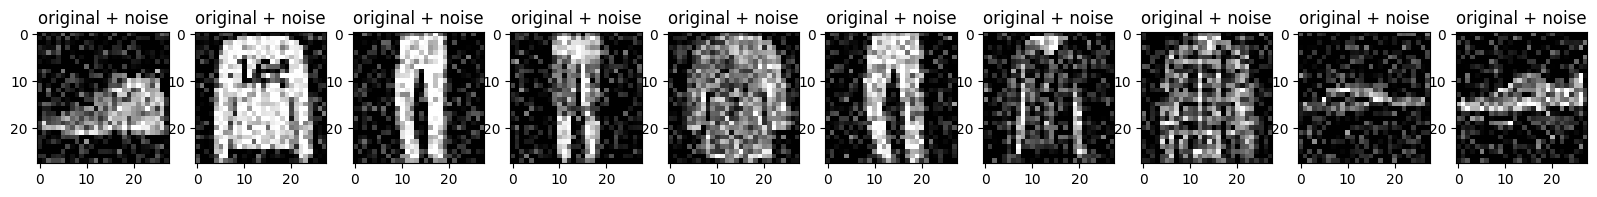

In [ ]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

### Define a convolutional autoencoder

In this example, you will train a convolutional autoencoder using  [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) layers in the `encoder`, and [Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) layers in the `decoder`.

In [ ]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.0337 - val_loss: 0.0097
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0093 - val_loss: 0.0086
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0084 - val_loss: 0.0080
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0078 - val_loss: 0.0076
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0075 - val_loss: 0.0074
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0074 - val_loss: 0.0075
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0073 - val_loss: 0.0073
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0072 - val_loss: 0.0072
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0071 - val_loss: 0.0071
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0071 - val_loss: 0.0071


Let us take a look at a summary of the encoder. Notice how the images are downsampled from 28x28 to 7x7.

In [ ]:
autoencoder.encoder.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 8)        │         1,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,320 (5.16 KB)

 Trainable params: 1,320 (5.16 KB)

 Non-trainable params: 0 (0.00 B)

The decoder upsamples the images back from 7x7 to 28x28.

In [ ]:
autoencoder.decoder.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_transpose                │ (32, 14, 14, 8)        │           584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (32, 28, 28, 16)       │         1,168 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 28, 28, 1)        │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,897 (7.41 KB)

 Trainable params: 1,897 (7.41 KB)

 Non-trainable params: 0 (0.00 B)

Plotting both the noisy images and the denoised images produced by the autoencoder.

In [ ]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

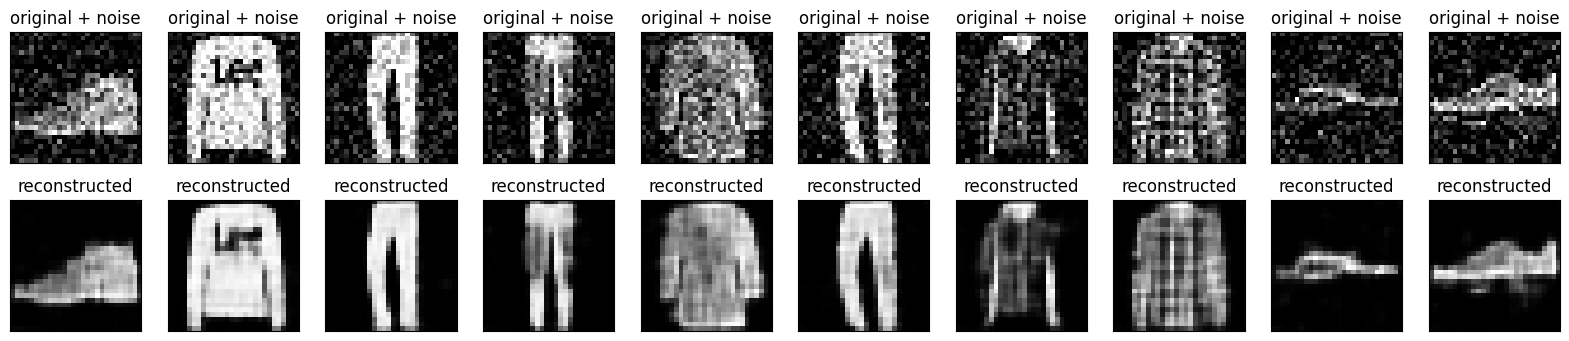

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

## Third example: Anomaly detection


In this example, you will train an autoencoder to detect anomalies on the [ECG5000 dataset](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000). This dataset contains 5,000 [Electrocardiograms](https://en.wikipedia.org/wiki/Electrocardiography), each with 140 data points. You will use a simplified version of the dataset, where each example has been labeled either `0` (corresponding to an abnormal rhythm), or `1` (corresponding to a normal rhythm). You are interested in identifying the abnormal rhythms.

The goal of this example is to illustrate anomaly detection concepts you can apply to larger datasets, where you do not have labels available (for example, if you had many thousands of normal rhythms, and only a small number of abnormal rhythms).

How will you detect anomalies using an autoencoder? Recall that an autoencoder is trained to minimize reconstruction error. You will train an autoencoder on the normal rhythms only, then use it to reconstruct all the data. Our hypothesis is that the abnormal rhythms will have higher reconstruction error. You will then classify a rhythm as an anomaly if the reconstruction error surpasses a fixed threshold.

### Load ECG data

In [ ]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [ ]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

Normalize the data to `[0,1]`.


In [ ]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

You will train the autoencoder using only the normal rhythms, which are labeled in this dataset as `1`. Separate the normal rhythms from the abnormal rhythms.

In [ ]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

Plot a normal ECG.

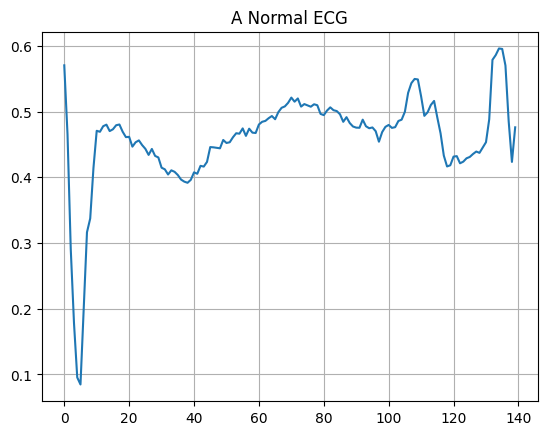

In [ ]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

Plot an anomalous ECG.

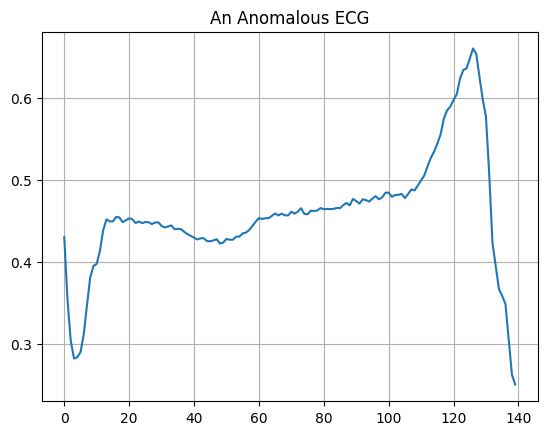

In [ ]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

### Build the model

In [ ]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [ ]:
autoencoder.compile(optimizer='adam', loss='mae')

Notice that the autoencoder is trained using only the normal ECGs, but is evaluated using the full test set.

In [ ]:
history = autoencoder.fit(normal_train_data, normal_train_data,
          epochs=20,
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 483ms/step - loss: 0.0596 - val_loss: 0.0531
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0559 - val_loss: 0.0516
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0534 - val_loss: 0.0504
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0505 - val_loss: 0.0488
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0473 - val_loss: 0.0468
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0439 - val_loss: 0.0452
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0407 - val_loss: 0.0433
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0376 - val_loss: 0.0421
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0346 - val_loss: 0.0408
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0320 - val_loss: 0.0399
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0303 - val_loss: 0.0388
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0290 - val_loss: 0.0382


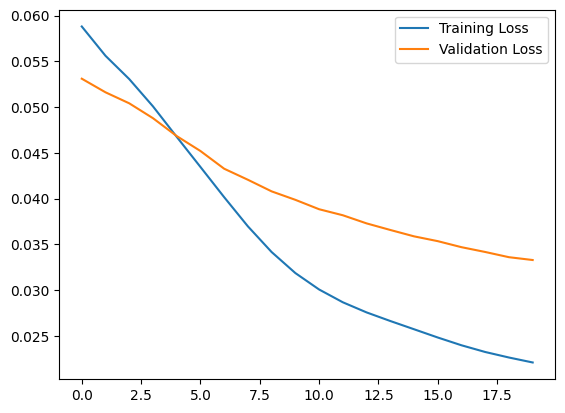

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

You will classify an ECG as anomalous if the reconstruction error is greater than one standard deviation from the normal training examples. First, let us plot a normal ECG from the training set, the reconstruction after it's encoded and decoded by the autoencoder, and the reconstruction error.

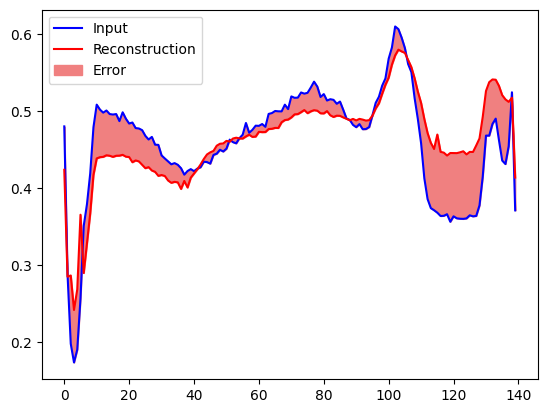

In [ ]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Create a similar plot, this time for an anomalous test example.

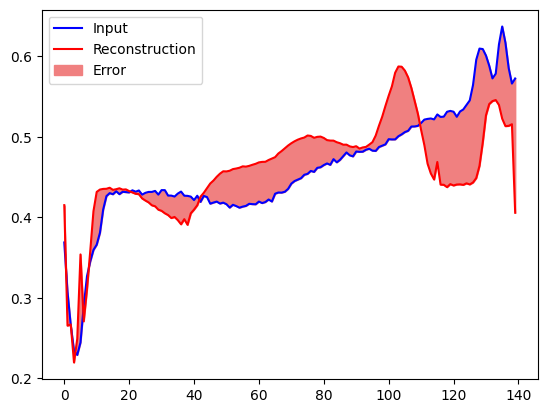

In [ ]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### Detect anomalies

Detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold. You will calculate the mean average error for normal examples from the training set, then classify future examples as anomalous if the reconstruction error is higher than one standard deviation from the training set.


Plot the reconstruction error on normal ECGs from the training set

74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


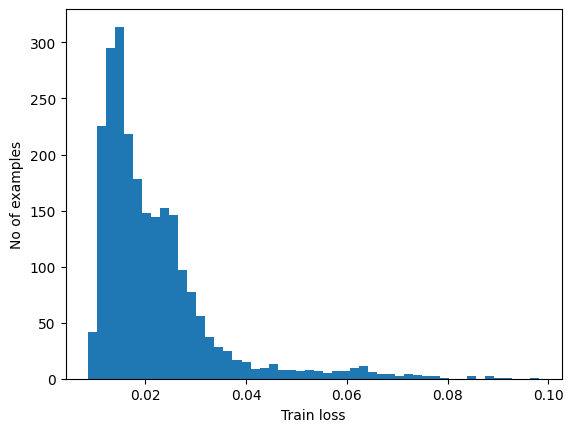

In [ ]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

Choose a threshold value that is one standard deviations above the mean.

In [ ]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.033421844


Note: There are other strategies you could use to select a threshold value above which test examples should be classified as anomalous, the correct approach will depend on your dataset.

If you examine the reconstruction error for the anomalous examples in the test set, you will notice most have greater reconstruction error than the threshold. By varing the threshold, you can adjust the precision and recall of your classifier.

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


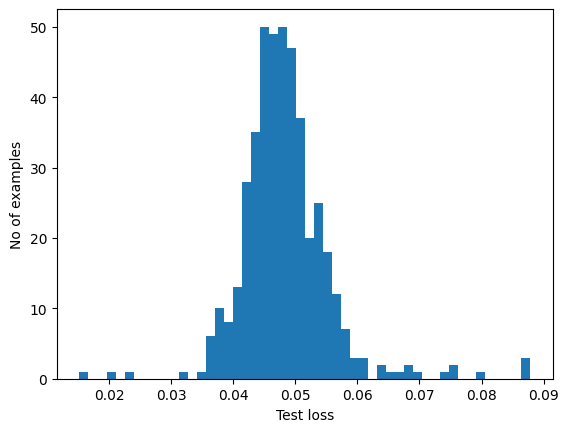

In [ ]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

Classify an ECG as an anomaly if the reconstruction error is greater than the threshold.

In [ ]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [ ]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.942
Precision = 0.9921568627450981
Recall = 0.9035714285714286


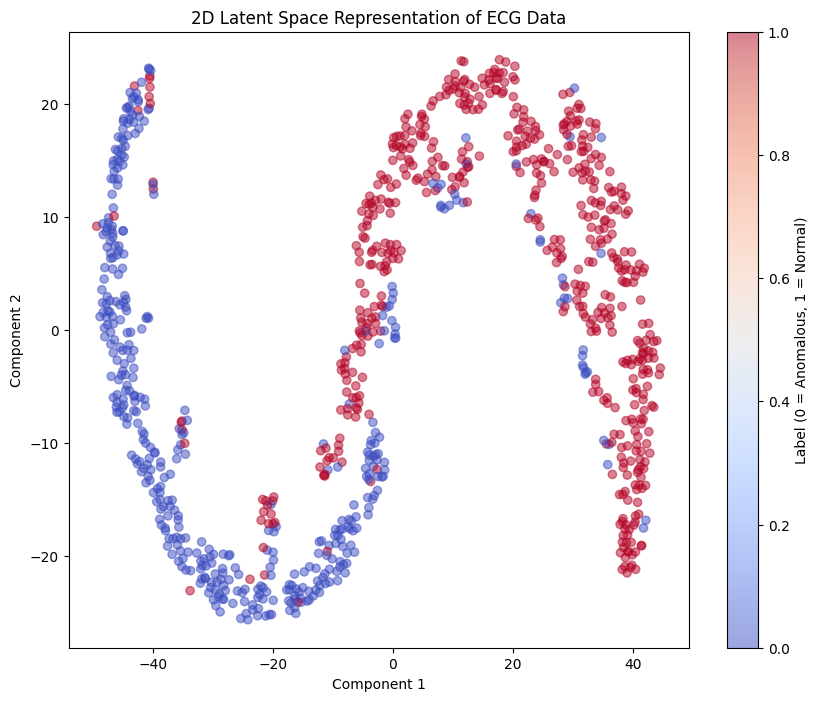

In [ ]:
# *******************************
# TASK 2 - VISUALIZE LATENT SPACE (Using t-SNE)
# *******************************

# Use a trained autoencoder to visualize how MNIST digits are clustered in
# the latent space. Use a trained encoder to project test images into the
# latent space. Then. use t-SNE or PCA to reduce the dimensionality to 2D.
# Plot the 2D scatter plot with different colors for each digit.

# WRITE YOUR CODE HERE
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Step 1: Get the latent space representations (encoded data)
latent_space = autoencoder.encoder(test_data)

# Step 2: Apply PCA or t-SNE for dimensionality reduction

# Using t-SNE
tsne = TSNE(n_components=2, random_state=42)
latent_2d_tsne = tsne.fit_transform(latent_space)

# Step 3: Plot the 2D scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(latent_2d_tsne[:, 0], latent_2d_tsne[:, 1], c=test_labels, cmap='coolwarm', alpha=0.5)
plt.title('2D Latent Space Representation of ECG Data')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(label='Label (0 = Anomalous, 1 = Normal)')
plt.show()

# *******************************
# *******************************

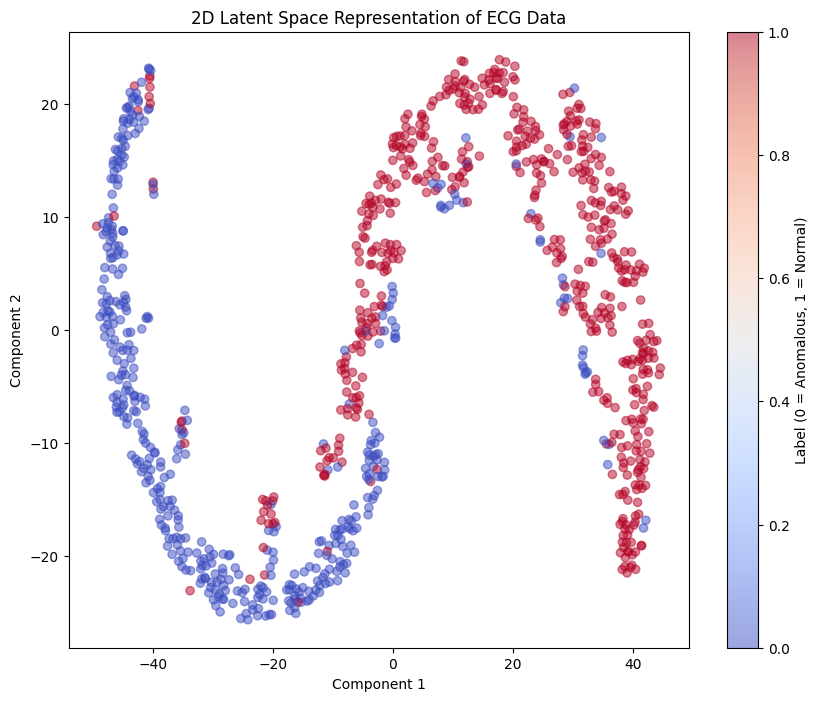

In [ ]:
# *******************************
# TASK 2 - VISUALIZE LATENT SPACE (Using PCA)
# *******************************

# Use a trained autoencoder to visualize how MNIST digits are clustered in
# the latent space. Use a trained encoder to project test images into the
# latent space. Then. use t-SNE or PCA to reduce the dimensionality to 2D.
# Plot the 2D scatter plot with different colors for each digit.

# WRITE YOUR CODE HERE
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Step 1: Get the latent space representations (encoded data)
latent_space = autoencoder.encoder(test_data)

# Step 2: Apply PCA or t-SNE for dimensionality reduction

# Using PCA
pca = PCA(n_components=2)
latent_2d_pca = pca.fit_transform(latent_space)

# Step 3: Plot the 2D scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(latent_2d_tsne[:, 0], latent_2d_tsne[:, 1], c=test_labels, cmap='coolwarm', alpha=0.5)
plt.title('2D Latent Space Representation of ECG Data')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(label='Label (0 = Anomalous, 1 = Normal)')
plt.show()

# *******************************
# *******************************


# **Task 1: Visualizing First-Layer Encoder Weights of an Autoencoder**

This task aims to **analyze the internal representations learned by the first encoder layer** of a trained autoencoder. The focus is on visualizing the learned weights to gain intuition about what the model captures from the input data — particularly whether it learns fundamental visual patterns like **edges, textures, or blobs**.

### **Code Breakdown**

1. **Weight Extraction**:  
   The code begins by extracting the **weights and biases** from the first hidden layer of the autoencoder’s encoder. This layer is usually fully connected and connects each input pixel (flattened from a 28x28 image) to hidden neurons. Each **weight vector** represents how a single hidden neuron responds to the input pixels.

2. **Transpose for Filter Representation**:  
   Since the weights are organized such that each column in the original matrix corresponds to a hidden neuron, the code transposes the weight matrix to bring the neurons (filters) into row-wise format — each row is a 784-dimensional vector (28x28) corresponding to one filter.

3. **Reshaping and Visualization**:  
   Each 784-length weight vector is reshaped into a **28x28 grid** and displayed as an image using `imshow` from Matplotlib. This helps to visualize what type of input pattern each hidden neuron responds to. The color map `'viridis'` is used to highlight the strength and polarity of the weights, where **yellow represents strong positive values** and **blue/purple represents strong negative values**.


### **Output Analysis**

- **Filter Patterns**:  
  The resulting visualizations show filters that capture a mix of **edge-like**, **texture-like**, and **blob-like** structures. For example:
  - Filters like 2, 3, 4, 6, 7,and  9 show more defined lines and transitions, indicating that the model is capturing **edge features**.
  - Filters like 1, 5, 8, and 10 display more scattered patterns, indicative of **texture or local blob detection**.

| **Filter** | **Visual Pattern** | **Category**         | **Reasoning**                                                                 |
|------------|--------------------|----------------------|--------------------------------------------------------------------------------|
| Filter 1   | Diffuse, scattered patches | **Blob-like**         | No clear lines or directional changes, but local regions of activation         |
| Filter 2   | Vertical textures   | **Edge-like**         | Displays oriented structures resembling vertical edge detectors                |
| Filter 3   | Line structures     | **Edge-like**         | Shows linear transitions indicating sensitivity to directional changes         |
| Filter 4   | Mixed signals       | **Edge-like**         | Contains a blend of patterns, but noticeable horizontal/vertical changes       |
| Filter 5   | Brighter central region | **Blob-like**         | Emphasizes localized intensity patterns over directional ones                  |
| Filter 6   | Curved/textured patterns | **Edge-like**         | Suggests curved or wavy edge detection rather than isolated intensity spots    |
| Filter 7   | Faint vertical lines| **Edge-like**         | Subtle vertical edge patterns visible                                          |
| Filter 8   | Patchy, clustered spots | **Blob-like**         | Dominated by local regions of contrast, with no sharp linear separation        |
| Filter 9   | Grid-like edges     | **Edge-like**         | Exhibits grid or checker-like structures resembling high-frequency edges       |
| Filter 10  | Soft patches with flow | **Blob-like**         | Not clearly directional, has a smooth, flowing pattern resembling textures     |


- **Feature Sensitivity**:  
  Each filter can be seen as a **feature detector**. The pattern of the weights suggests which parts of the image space each neuron is sensitive to. The brighter areas in the visualized weights signify parts of the input that activate the neuron more strongly.


### **Relation to CNNs and Feature Learning**

- Although the encoder layer in this case is **fully connected**, the learned features are similar to what one would expect from the **first convolutional layer of a CNN**. CNNs typically learn edge detectors or gradient-based filters early on, as these are fundamental to understanding shapes and patterns in images.

- The key difference is **how** the features are learned:
  - In **CNNs**, spatial locality and structure are hardcoded into the architecture via convolution.
  - In a **fully connected autoencoder**, such features are learned **implicitly** through backpropagation, without any structural bias toward spatial locality.

### **My Observations:**

- **Low-Level Feature Learning**: Even without convolution, the model learns to detect edges, textures, and localized patterns — the foundational building blocks of image understanding.
- **Weight Visualization as Insight**: Visualizing weights helps to demystify neural networks by showing that even abstract-looking numbers encode meaningful spatial patterns.
- **Model Interpretation**: This technique is a step toward **interpretable AI**, offering a window into how the model perceives and processes data.


---


# **Task-02: Latent Space Visualization**

The aim of this task is to understand how well a trained autoencoder captures and separates the underlying structure of ECG signal data in its latent space. By visualizing the encoded data, I was able to gain insights into the discriminative power of the learned representations.


### **Latent Representation Extraction**

Using the encoder component of the autoencoder, each ECG test sample is transformed into its corresponding latent vector—a compressed representation capturing the most relevant features of the input. These high-dimensional representations are the internal "summary" the model uses to reconstruct or classify inputs.


### **Dimensionality Reduction for Visualization**

Since latent vectors are typically of higher dimensions, a dimensionality reduction technique is applied to map them to a 2D space. In this case, **t-distributed Stochastic Neighbor Embedding (t-SNE) and PCA** both are used to preserve the local structure of the data and make it interpretable in two dimensions. The goal is to reveal clusters, patterns, or separations that indicate how well the autoencoder distinguishes between different classes of data.


### **Scatter Plot Interpretation**

The 2D scatter plot displays each encoded sample as a point in space. These points are color-coded based on their class labels:
- **Red**: Normal ECG signals (label = 1)
- **Blue**: Anomalous ECG signals (label = 0)

The visualization exhibits a **U-shaped structure**, with clear clusters forming for each class. Normal and anomalous samples largely occupy distinct regions of the latent space, indicating that the model has successfully learned to separate the two categories in its internal representation.


### **Insights from the Visualization**

- **Class Separation**: The separation between normal and anomalous points reflects the model's ability to capture critical features that differentiate the two.
- **Overlap Regions**: Some overlap between classes is visible in transition areas, suggesting edge cases or data points with ambiguous patterns.
- **Interpretability**: This visualization provides a transparent window into the "thinking process" of the autoencoder and supports the reliability of its representations for downstream tasks like anomaly detection.


### **Conclusion**

The 2D latent space visualization confirms that the autoencoder effectively learns meaningful and distinguishable features of ECG data. It demonstrates not only the clustering tendencies of similar signals but also the model’s potential in applications such as automated anomaly detection in biomedical signals. It was also observed that **PCA and t-SNE both gave almost the same results.**


---